<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

## HW: Deep Learning ##

HW submission by group (up to 4 people)
* John Doe <johndoe@illinois.edu>
* Jane Roes <janeroe@illinois.edu>

**Redfin Property Type Prediction**:  Download propery data from Redfin <https://www.redfin.com/> for several neighborhoods of Chicago.  Use multilayer neural networks to predict property type Single Family Residential vs Condo/Co-op based on the feature set
* Square Feet
* number of Beds
* number of Baths
* Year built
* HOA/Month
* Price

Use training, validation, and testing to vary the number and dimensions of layers.

In [ ]:
import torch
import numpy
import pandas as pd
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import itertools
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pd.read_csv(loc,**kwargs)
    return out

In [ ]:
url="https://www.redfin.com"
fname=("redfin_data.csv","https://drive.google.com/file/d/1BFgKwV58YkPX_PRWMuKRHQoT6T0de_Qf/view?usp=sharing")
plot_title="Home Asking Price (Redfin)"
data_color="red"
markersize=2
thinlinesize=2
SEED=0

In [ ]:
data_raw=getfile(fname)
data_raw

local file not found; accessing Google Drive


,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Single Family Residential,333 Dodge Ave,Evanston,IL,60202,339900,3.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/333-Dodge-A...,MRED,11818689,N,Y,42.024226,-87.699124
1,MLS Listing,NaN,Condo/Co-op,2254 Sherman Ave #2,Evanston,IL,60201,199000,2.0,1.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/2254-Sherma...,MRED,11831019,N,Y,42.059131,-87.682292
2,MLS Listing,NaN,Single Family Residential,2701 Noyes St,Evanston,IL,60201,1075000,5.0,3.5,...,Active,August-5-2023 11:00 AM,August-5-2023 01:00 PM,https://www.redfin.com/IL/Evanston/2701-Noyes-...,MRED,11850222,N,Y,42.058239,-87.710956
3,MLS Listing,NaN,Townhouse,1507 Wilder St,Evanston,IL,60202,825000,4.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1507-Wilder...,MRED,11849960,N,Y,42.040571,-87.693225
4,MLS Listing,NaN,Single Family Residential,9409 Crawford Ave,Evanston,IL,60203,525000,3.0,1.5,...,Active,August-6-2023 02:00 PM,August-6-2023 04:00 PM,https://www.redfin.com/IL/Evanston/9409-Crawfo...,MRED,11849554,N,Y,42.052003,-87.727151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,MLS Listing,NaN,Vacant Land,1821 Lake St,Evanston,IL,60201,350000,NaN,NaN,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1821-Lake-S...,MRED,11675879,N,Y,42.044480,-87.698591
104,MLS Listing,NaN,Condo/Co-op,1508 Hinman Ave Unit 4B,Evanston,IL,60201,344900,2.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1508-Hinman...,MRED,11651979,N,Y,42.045088,-87.678878
105,MLS Listing,NaN,Single Family Residential,90 Kedzie St,Evanston,IL,60202,5750000,5.0,5.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/90-Kedzie-S...,MRED,11649944,N,Y,42.031828,-87.669248
106,MLS Listing,NaN,Vacant Land,1815 Hovland Ct,Evanston,IL,60201,110000,NaN,NaN,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1815-Hovlan...,MRED,11385578,N,Y,42.050800,-87.700945


In [ ]:
data_raw["PROPERTY TYPE"].value_counts()

Single Family Residential    50
Condo/Co-op                  38
Vacant Land                   9
Multi-Family (2-4 Unit)       6
Townhouse                     5
Name: PROPERTY TYPE, dtype: int64

In [ ]:
data = data_raw.copy()

data["SQUARE FEET/1000"]=data["SQUARE FEET"]/1000
data["PRICE/$1M"]=data["PRICE"]/1.0E6
data = data[(data["PROPERTY TYPE"] == "Single Family Residential") | (data["PROPERTY TYPE"] == "Condo/Co-op")]
data["SFR"] = (data["PROPERTY TYPE"] == "Single Family Residential").astype("int")

In [ ]:
label = ["SFR"]
features = ["SQUARE FEET/1000", "BEDS", "BATHS", "YEAR BUILT", "HOA/MONTH", "PRICE/$1M"]
data = data[label+features]

data.head()

,SFR,SQUARE FEET/1000,BEDS,BATHS,YEAR BUILT,HOA/MONTH,PRICE/$1M
0,1,1.520,3.0,2.0,1958.0,NaN,0.3399
1,0,0.900,2.0,1.0,1959.0,452.0,0.1990
2,1,3.135,5.0,3.5,2023.0,NaN,1.0750
4,1,1.600,3.0,1.5,1949.0,NaN,0.5250
5,0,1.032,2.0,2.0,2002.0,721.0,0.4500


In [ ]:
data.describe()

,SFR,SQUARE FEET/1000,BEDS,BATHS,YEAR BUILT,HOA/MONTH,PRICE/$1M
count,88.000000,77.000000,88.000000,88.000000,87.000000,39.000000,88.000000
mean,0.568182,2.517831,3.375000,2.448864,1946.241379,777.794872,0.801621
std,0.498168,1.987189,1.585223,1.351967,35.631501,647.429093,0.888103
min,0.000000,0.687000,1.000000,1.000000,1864.000000,257.000000,0.088000
25%,0.000000,1.260000,2.000000,1.500000,1922.500000,424.500000,0.313500
50%,1.000000,1.738000,3.000000,2.000000,1949.000000,566.000000,0.512500
75%,1.000000,3.200000,5.000000,3.000000,1964.000000,874.500000,0.866875
max,1.000000,11.003000,8.000000,6.500000,2023.000000,3904.000000,5.750000


In [ ]:
df_preprocessed = data.copy()

scaler = StandardScaler()

df_preprocessed[features] = df_preprocessed[features].fillna(df_preprocessed[features].mean())
df_preprocessed[features] = scaler.fit_transform(df_preprocessed[features])

In [ ]:
#We divide the dataset in train (70%), test (15%) and validation (15%) sets
# we use the stratify feature to account for the slight bias between SFR and Condo/Co-op (56% SFR, 44% Condos)
train, test_val = train_test_split(df_preprocessed, train_size = 0.70, stratify=df_preprocessed.SFR)
test, val = train_test_split(test_val, train_size = 0.5, stratify=test_val.SFR)

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super(FeedForwardNN, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.Tanh())  # Add tanh activation for hidden layers

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

input_size = 6  # 6 predictors
architectures = [[input_size] + [i] * j + [1] for i in [8, 16, 32, 64] for j in range(3, 6)]

models = []
for arch in architectures:
    model = FeedForwardNN(input_size, arch)
    models.append(model)

# Print the created models
for i, model in enumerate(models):
    print(f"Model {i}:")
    print(model)

Model 0:
FeedForwardNN(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
Model 1:
FeedForwardNN(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Tanh()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)
Model 2:
FeedForwardNN(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=8, bias=True)
    

In [ ]:
X_tensor = torch.FloatTensor(train.drop(label, axis=1).values)
y_tensor = torch.FloatTensor(train[label].values).view(-1, 1)

In [ ]:
for i, model in enumerate(models):
  print(f"Model {i}:")
  loss_function = nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Experimented with learning rate

  epochs = 10000
  for epoch in range(epochs):
      outputs = model(X_tensor)
      loss = loss_function(outputs, y_tensor)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Model 0:
Epoch [500/10000], Loss: 0.2033
Epoch [1000/10000], Loss: 0.1380
Epoch [1500/10000], Loss: 0.0939
Epoch [2000/10000], Loss: 0.0744
Epoch [2500/10000], Loss: 0.0131
Epoch [3000/10000], Loss: 0.0053
Epoch [3500/10000], Loss: 0.0032
Epoch [4000/10000], Loss: 0.0023
Epoch [4500/10000], Loss: 0.0017
Epoch [5000/10000], Loss: 0.0014
Epoch [5500/10000], Loss: 0.0012
Epoch [6000/10000], Loss: 0.0010
Epoch [6500/10000], Loss: 0.0009
Epoch [7000/10000], Loss: 0.0008
Epoch [7500/10000], Loss: 0.0007
Epoch [8000/10000], Loss: 0.0006
Epoch [8500/10000], Loss: 0.0006
Epoch [9000/10000], Loss: 0.0005
Epoch [9500/10000], Loss: 0.0005
Epoch [10000/10000], Loss: 0.0005
Model 1:
Epoch [500/10000], Loss: 0.2114
Epoch [1000/10000], Loss: 0.1047
Epoch [1500/10000], Loss: 0.0093
Epoch [2000/10000], Loss: 0.0034
Epoch [2500/10000], Loss: 0.0020
Epoch [3000/10000], Loss: 0.0014
Epoch [3500/10000], Loss: 0.0011
Epoch [4000/10000], Loss: 0.0009
Epoch [4500/10000], Loss: 0.0008
Epoch [5000/10000], Loss: 

In [ ]:
X_val_tensor = torch.FloatTensor(val.drop(label, axis=1).values)
y_val_tensor = torch.FloatTensor(val[label].values).view(-1, 1)

In [ ]:
validation_losses =[]
for i, model in enumerate(models):
  model.eval()
  with torch.no_grad():
        val_outputs = model(X_val_tensor)
  val_loss = loss_function(val_outputs, y_val_tensor)
  validation_losses.append(val_loss)
print(validation_losses)

[tensor(0.4071), tensor(0.2034), tensor(0.4439), tensor(0.1472), tensor(0.3168), tensor(0.4998), tensor(0.2104), tensor(0.2210), tensor(0.3021), tensor(0.3006), tensor(0.4336), tensor(0.3847)]


In [ ]:
import numpy as np
validation_losses_np = np.array(validation_losses)
index_of_min_loss = np.argmin(validation_losses_np)
print(index_of_min_loss)

3


In [ ]:
print(f"model{index_of_min_loss}")
print(models[index_of_min_loss])

model3
FeedForwardNN(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [ ]:
X_test_tensor = torch.FloatTensor(test.drop(label, axis=1).values)
y_test_tensor = torch.FloatTensor(test[label].values).view(-1, 1)

In [ ]:
model = models[index_of_min_loss]
model.eval()
with torch.no_grad():
  test_outputs = model(X_test_tensor)
test_loss = loss_function(test_outputs, y_test_tensor)

print(test_loss)

tensor(0.1820)


In [ ]:
predicted_property = test_outputs.numpy()
predicted_class = (predicted_property >= 0.5).astype(int)
results = pd.DataFrame({'Predicted Property': predicted_class.flatten(), 'Actual Property': test['SFR']})
results

,Predicted Property,Actual Property
88,0,0
9,1,1
38,0,0
76,0,0
101,1,1
90,1,1
83,1,1
70,1,1
52,1,1
75,1,0


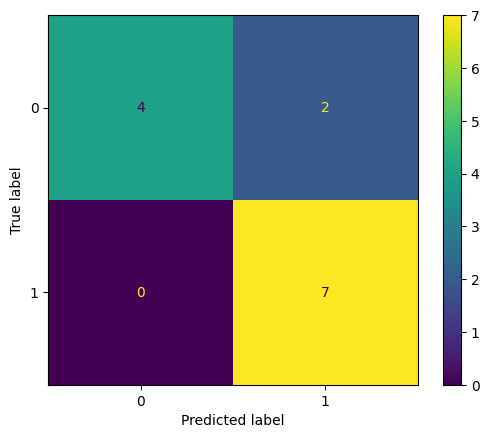

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = results['Actual Property'],y_pred= results['Predicted Property'])